# Problem Set 7, due May 6 at 11:59pm

<span style="color:red">WARNING:</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful!

One suggestion: Start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

Display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images? Throw away all people for whom you have fewer than 10 images.

In [1]:
import pandas as pd
import numpy as np
import os
import time
from skimage import color
from skimage import io
from matplotlib import gridspec
import matplotlib.image as mpimg
import IPython
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_dir = 'C:/Users/Dimitris/Downloads/2020/lfw_funneled'
image_num = {}
for f in os.listdir(image_dir):
    if os.path.isdir(os.path.join(image_dir, f)):
        image_num[f] = len(os.listdir(os.path.join(image_dir, f)))
image_meta = pd.DataFrame({'name': list(image_num.keys()), 'image_num': list(image_num.values())})


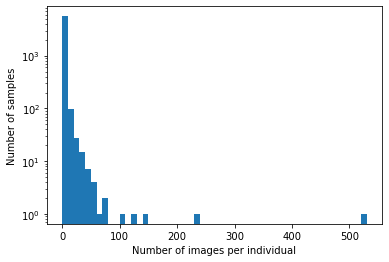

In [3]:
plt.hist(image_meta.image_num, bins=np.arange(0, image_meta.image_num.max()+10, 10))
plt.xlabel('Number of images per individual')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.show()

In [4]:
image_meta[image_meta.image_num == image_meta.image_num.max()]

,name,image_num
1870,George_W_Bush,530


George W. Bush has the most images.

In [5]:
image_selected = image_meta[image_meta.image_num >= 10]
print(len(image_selected))


158


### 1.2. Show some faces!

1. Pick 8 random images from the dataset and display them in a 2 x 4 grid.
2. Create a single image that shows the "average face" -- i.e., each pixel should display the average value of that pixel across all of the images. 
3. For each pixel, calculate the standard deviation of values for that pixel (you will have a different standard deviation for each of the three color channels, feel free to just show the standard deviation of one of the channels, or to average the standard deviation of the three channels at each pixel). Plot these standard deviations as a heatmap.

What do you notice about the distribution of mean and standard deviation values in these images? (e.g., are they evenly distributed)

Vladimir_Putin_0001.jpg
Walter_Mondale_0001.jpg
Jeb_Bush_0001.jpg
Jackie_Chan_0001.jpg
Nestor_Kirchner_0001.jpg
Condoleezza_Rice_0001.jpg
James_Blake_0001.jpg
Donald_Rumsfeld_0001.jpg


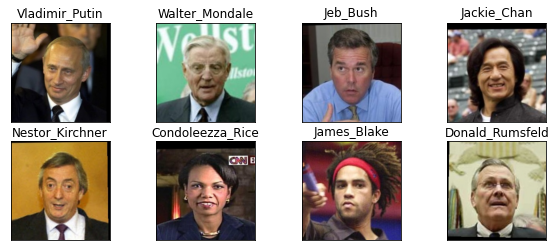

In [6]:
 # your code here
fig, ax = plt.subplots(figsize=(10, 4))
gs = gridspec.GridSpec(2, 4)
for idx, name in enumerate(image_selected.sample(n=8, random_state=111)['name']):
    image_this = os.listdir(os.path.join(image_dir, name))[0]
    #print( os.listdir(os.path.join(image_dir, name)))
    print( os.listdir(os.path.join(image_dir, name))[0])
    img = mpimg.imread(os.path.join(image_dir, name, image_this))
    ax = plt.subplot(gs[idx])
    plt.imshow(img)
    plt.title(name)
    plt.xticks([])
    plt.yticks([])

In [6]:
all_images_color = []
for idx, name in enumerate(image_selected['name']):
    for image_this in os.listdir(os.path.join(image_dir, name)):
        img = mpimg.imread(os.path.join(image_dir, name, image_this))
        all_images_color.append(img)

len(all_images_color)


4324

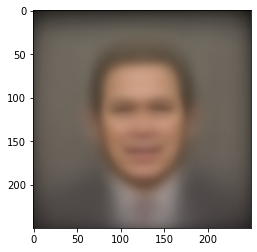

In [7]:
all_images_color_array = np.array(all_images_color)
all_images_avg = np.mean(all_images_color_array, axis=0)
plt.imshow(all_images_avg.astype('uint8'))


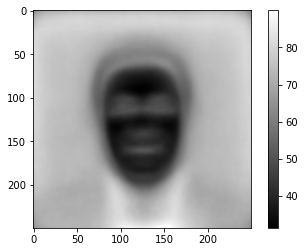

In [9]:
all_images_std = np.std(all_images_color_array, axis=0)
plt.imshow(all_images_std[:,:,0], cmap='gray')
plt.colorbar()  

Both the mean and standard deviation of these images are not evenly distributed. The mean values in these images look like a real face. The standard deviations in these images are very interesting. The face area has the lowest variation, while the background has the highest variation, implying that the background might determine the cluster results.

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discuseed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [8]:
from sklearn.metrics import pairwise_distances_argmin


def ClusterKM(X, k):
    # Randomly choose clusters
    sample_idx = np.random.choice(X.shape[0], k)
    centroids = X[sample_idx]
    cnt = 0
    while True:
        # Assign labels based on closest center
        idx = pairwise_distances_argmin(X, centroids)
        new_centroids = np.array([X[idx == i].mean(0) for i in range(k)])
        cnt += 1
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
        
    return centroids, idx, cnt

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. 

c:\users\dimitris\miniconda3\envs\drl2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


4


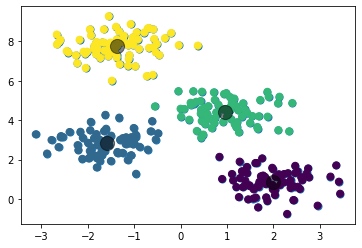

In [13]:
# does everything work as expected?

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

myCenters, myIdx,cnt = ClusterKM(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=myIdx, s=50, cmap='viridis')
plt.scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5);

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=20. Make sure to normalize your data first! Show a 20 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250*250*3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- an even if it is! -- it might take a long time for your algorithm to converge. If your computer is old, it might even take a very long time for you to simply normalize your data. If you are running into such problems, you may convert your RGB images into greyscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function).



In [12]:
# convert to gray
all_images = []
for idx, name in enumerate(image_selected['name']):
    for image_this in os.listdir(os.path.join(image_dir, name)):
        img = io.imread(os.path.join(image_dir, name, image_this), as_gray=True)
        all_images.append(img)

len(all_images)

4324

In [13]:
print(all_images[0])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.25660549 0.2683702  0.27229176 ... 0.         0.         0.        ]
 [0.26444863 0.2683702  0.2683702  ... 0.         0.         0.        ]
 [0.27229176 0.27229176 0.27229176 ... 0.         0.         0.        ]]


In [14]:
all_images_array = np.array(all_images)
print(all_images_array.shape)

(4324, 250, 250)


In [15]:
all_images_array2 = all_images_array.reshape(all_images_array.shape[0], 250*250)
print(all_images_array2.shape)

(4324, 62500)


In [16]:
t1 = time.time()
myCenters, myIdx, cnt = ClusterKM(all_images_array2, 20)
print("Number of iterations until convergence for k-Means {}".format(cnt))
t2 = time.time()
print(t2 - t1)


Number of iterations until convergence for k-Means 83
250.99946570396423


In [19]:
# Compute SSE
from sklearn.metrics import pairwise_distances
Dists = pairwise_distances(all_images_array2, myCenters)
SSE_kM = 0
for i in range(len(Dists[:,0])):
    SSE_kM += np.min(Dists[i,:])**2
print("The sum of squared errors is {}".format(SSE_kM))

The sum of squared errors is 11629573.10175551


In [ ]:
ny = 20
nx = 2
dxs = 3
dys = 3
fig, ax = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny) )

for i in range(myCenters.shape[0]):
    idx = pairwise_distances_argmin(myCenters[i].reshape(1, 62500), all_images_array2, metric='euclidean')
    ax[i, 0].imshow(myCenters[i].reshape(250,250), cmap='gray')
    ax[i, 1].imshow(all_images_array2[idx].reshape(250,250), cmap='gray')

First of all, the background color of figures contributes to the cluster result. Some figures have black areas on the edge, which are also shown in the cetroid figures. Besides, the relative position and the orientation of the face are also important features.

Note I did not normalize the data because the grayscale images range from 0 to 1. If you use colorful images, the images should be normalized from 0-255 to 0-1 by dividing 255. Also, the normalization would not overcome the issue of different background color even though using the normalization method by subtracting mean and dividing standard deviation.

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself
 2. The cluster centroid closest to that image
 3. The closest image in the original dataset to that cluster centroid
 4. The closest image in the original dataset to the image of yourself


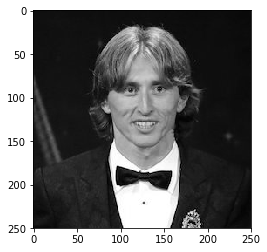

In [17]:
img = io.imread('/Users/guanghua/Downloads/photo.jpeg', as_grey=True)
plt.imshow(img, cmap='gray')

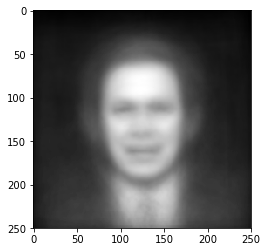

In [18]:
idx = pairwise_distances_argmin(img.reshape(1,62500), myCenters)
plt.imshow(myCenters[idx].reshape(250,250), cmap='gray')

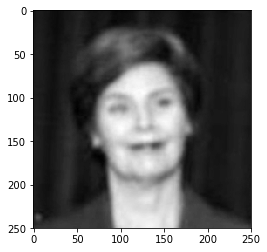

In [19]:
idx = pairwise_distances_argmin(myCenters[idx], all_images_array2)
plt.imshow(all_images_array2[idx].reshape(250,250), cmap='gray')

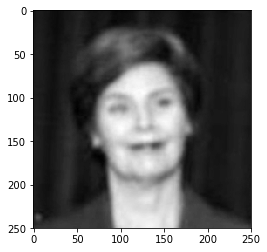

In [20]:
idx = pairwise_distances_argmin(img.reshape(1,62500), all_images_array2)
plt.imshow(all_images_array2[idx].reshape(250,250), cmap='gray')

## 3. PCA and Eigenfaces 

Begin by normalizing your data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(all_images_array2, test_size=0.5, random_state=42)

In [13]:
from sklearn.decomposition import PCA

comp_n = 100
pca = PCA(n_components = comp_n)
pca.fit(X_train)
vari = pca.explained_variance_ratio_
    
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(range(1, comp_n+1), np.cumsum(vari))

plt.xlabel('Components number')
plt.ylabel('Proportion of Variance Captured (0-1)')
plt.title('Amount of variance explained by PCA components')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.grid()

NameError: name 'X_train' is not defined

In [15]:
vari_cum = np.cumsum(vari)
np.argwhere(vari_cum > 0.75).min()

36

35 components are required to explain 75% of the variation in your original data?

### 3.2. Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

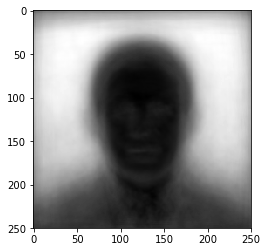

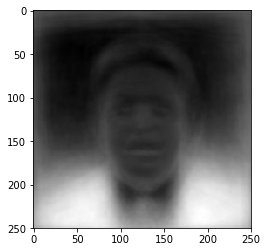

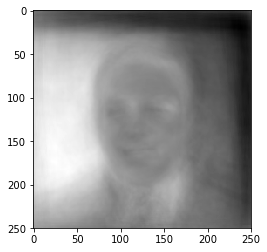

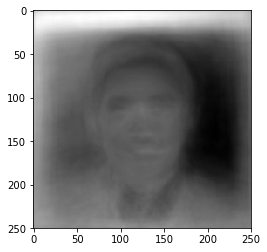

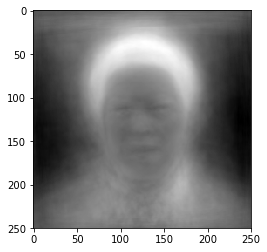

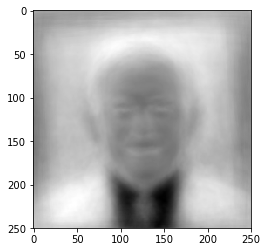

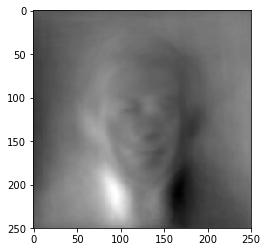

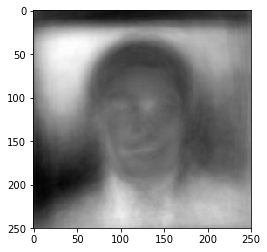

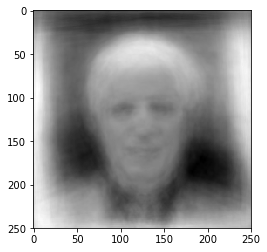

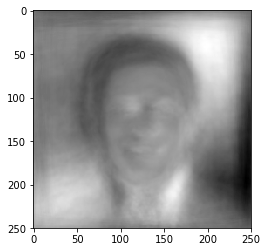

In [24]:
pca = PCA(n_components=10, whiten=True)
pca.fit(X_train)

for i in range(10):
    plt.imshow(pca.components_[i].reshape(250,250), cmap='gray')
    plt.show()

### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 50-dimensional space defined by the first 50 principal components.
 - Apply k-means clustering, with k=20, to the 50-dimensional projections of the training data. 
 - Display a 4 x 5 grid of images that shows what each of the 20 centroids look like after the centroid is projected back into the original-image space.

In [25]:
pca = PCA(n_components = 50)
pca.fit(X_train)
x_train_proj = pca.transform(X_train)
x_test_proj = pca.transform(X_test)

myCenters_pca, myIdx = ClusterKM(x_train_proj, 20)

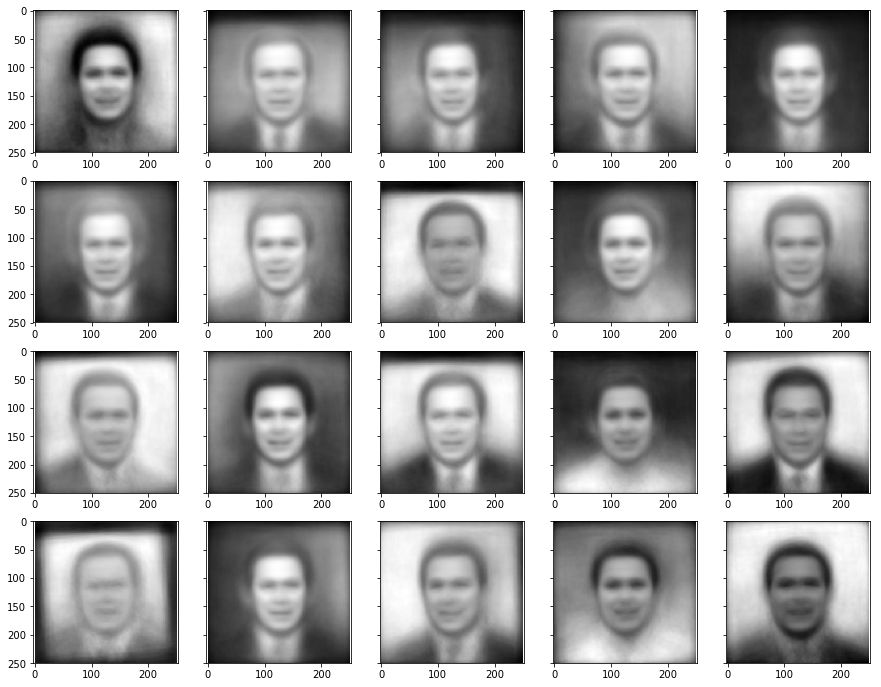

In [26]:
ny = 4
nx = 5
dxs = 3
dys = 3
fig, ax = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny))

for i in range(20):
    ax[i//5, i%5].imshow(pca.inverse_transform(myCenters_pca[i]).reshape(250,250), cmap='gray')

### 3.4. Recognition

Create a test set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 50-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 50-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

In [27]:
test_8 = X_test[np.random.choice(X_test.shape[0], 8)]
panda = io.imread('/Users/guanghua/Downloads/panda.png', as_grey=True).reshape(1,62500)
image_10 = np.concatenate((test_8, panda, img.reshape(1,62500)))
print(image_10.shape)

(10, 62500)


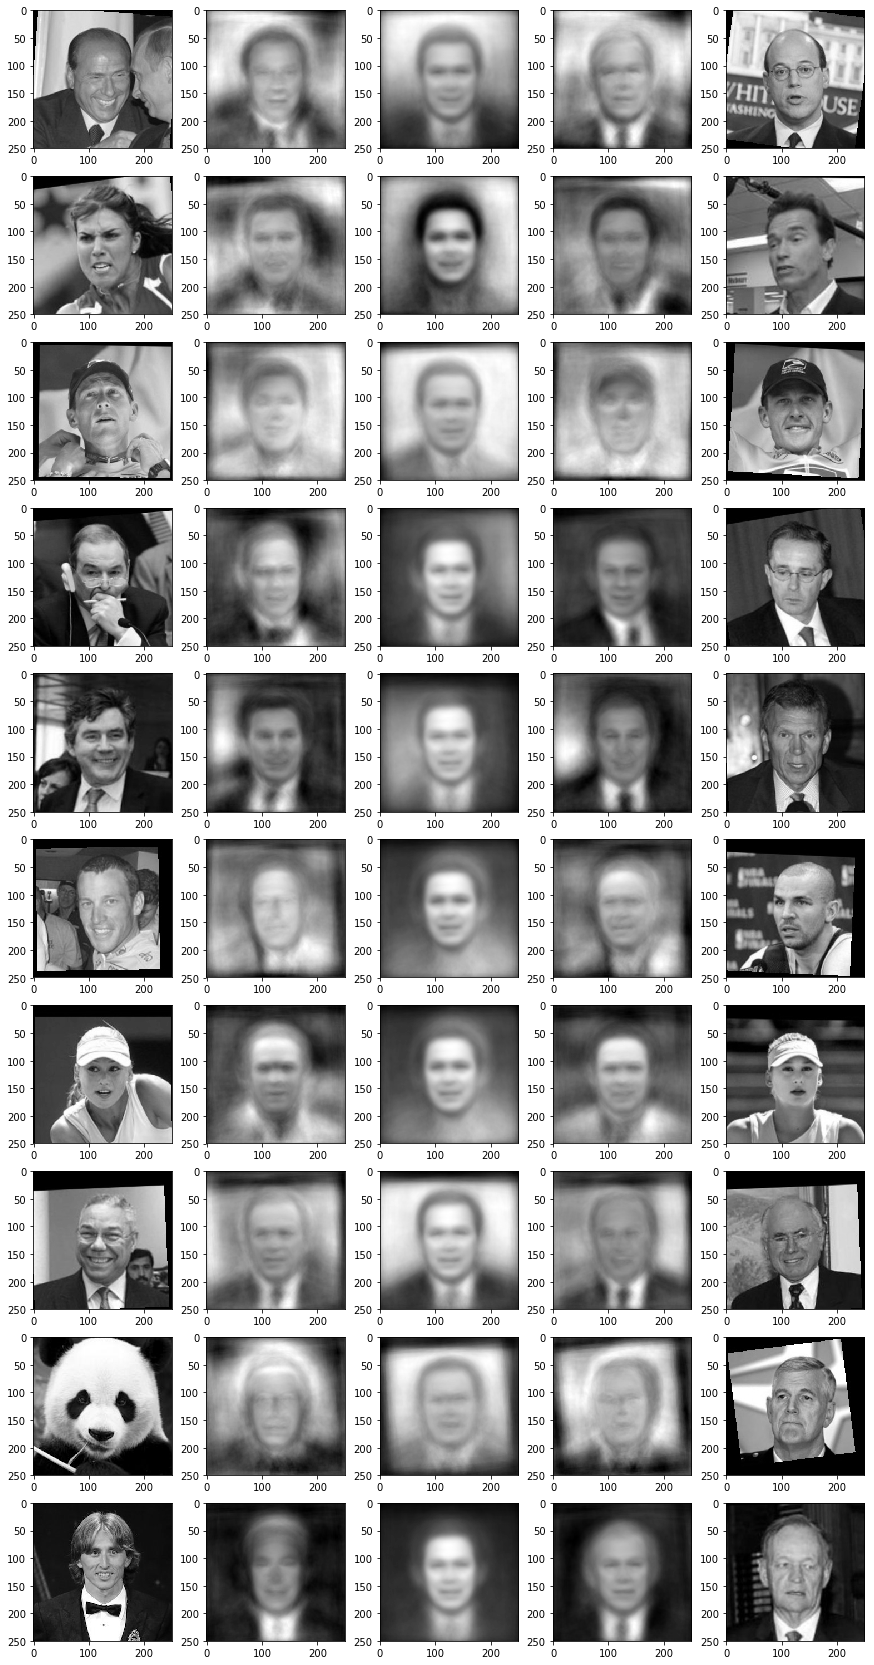

In [28]:
ny = 10
nx = 5
dxs = 3
dys = 3
fig, ax = plt.subplots(ny, nx, figsize=(dxs*nx, dys*ny))

for i in range(10):
    ax[i, 0].imshow(image_10[i].reshape(250,250), cmap='gray')
    x_proj = pca.transform(image_10[i].reshape(1, 62500))
    ax[i, 1].imshow(pca.inverse_transform(x_proj).reshape(250,250), cmap='gray')
    idx = pairwise_distances_argmin(x_proj, myCenters_pca, metric='euclidean')
    ax[i, 2].imshow(pca.inverse_transform(myCenters_pca[idx]).reshape(250,250), cmap='gray')
    idx = pairwise_distances_argmin(x_proj, x_train_proj, metric='euclidean')
    ax[i, 3].imshow(pca.inverse_transform(x_train_proj[idx]).reshape(250,250), cmap='gray')
    ax[i, 4].imshow(X_train[idx].reshape(250,250), cmap='gray')

### 3.5. (Extra credit) Share your results
Post the following to bCourses for people in the class to see:
 - The photo of yourself
 - The cluster centroid from 2.4 that is closest to that image
 - The closest image in the dataset to that cluster centroid
 - The reconstruction of your image after it has been projected and reprojected (i.e., #2 in 3.4)
 - The nearest centroid to the projection (i.e., #3 in 3.4)
 - The closest training image to that centroid (i.e., #5 in 3.4)

### 3.6. (Extra extra credit) PCA Implementation

Implement PCA yourself, without using sklearn. How does the running time of your algorithm compare to the running time of the sklearn version?

In [29]:
def pca_my(A, n_components=None):
    M = np.mean(A.T, axis=1)
    C = A - M
    # calculate covariance matrix of centered matrix
    V = np.cov(C.T)
    # eigendecomposition of covariance matrix
    values, vectors = np.linalg.eig(V)
    values_sum = sum(values)
    if n_components:
        values = values[:n_components]
        vectors = vectors[:,:n_components]
    r_transform = vectors.T.dot(C.T)
    return sum(values) / values_sum, r_transform

In [30]:
t0 = time.time()
comp_n = 10
pca = PCA(n_components = comp_n)
tran = pca.fit_transform(X_train[:,:1000])
vari = pca.explained_variance_ratio_
t1 = time.time()
print(t1 - t0)

0.9818289279937744


In [31]:
t0 = time.time()
# test only 1000 features because of the expensive computation
var, r_trans = pca_my(X_train[:,:1000], n_components = comp_n)
t1 = time.time()
print(t1- t0)

2.669124126434326


The PCA method in sklearn is faster because it used a different method (randomized SVD) to calculate the SVD, which is more efficient. I tried to use all the 62500 features. My kernel crashed. But the PCA method in sklearn works well.

**From [source code](https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/decomposition/pca.py#L163): If the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient 'randomized' method is enabled.**

### 3.7. (Extra extra extra credit): k-Means++
- In 2.1 you implemented k-Means clustering with random initialization of the centroids. In this part implement the k-Means++ version of the algorithm that uses a "smarter" initialization of the centroids in order to achieve faster convergence. Compare the number of iterations it took k-Means in 2.3 to converge with random initialization to the number of iterations it takes k-Means++. Also compare the sum of squared errors that you obtain for both methods. Use for both k=20 clusters. The following link shows the paper that proposed k-Means++.
http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

In [20]:
from sklearn.metrics import pairwise_distances
def ClusterKM_pp(X, k):
    # Choose clusters
    sample_idx = np.random.choice(X.shape[0], 1)
    centroids = np.zeros((1, len(X[0,:])))
    centroids[0, :] = X[sample_idx,:]
    for i in range(1, k):
        Dists = pairwise_distances(X, centroids)
        probs= np.zeros(len(X[:,0]))
        for j in range(len(X[:,0])):
            probs[j] = np.min(Dists[j,:])
        probs = probs/np.sum(probs)
        index = np.random.choice(range(len(X[:,0])), size=1, replace=True, p=probs)
        centroids = np.vstack((centroids, X[index,:]))
            
            
    
    cnt = 0
    while True:
        # Assign labels based on closest center
        idx = pairwise_distances_argmin(X, centroids)
        new_centroids = np.array([X[idx == i].mean(0) for i in range(k)])
        cnt += 1
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
        
    return centroids, idx, cnt

In [21]:
t1 = time.time()
myCenters, myIdx, cnt = ClusterKM_pp(all_images_array2, 20)
print("Number of iterations until convergence for k-Means {}".format(cnt))
t2 = time.time()
print(t2 - t1)

Number of iterations until convergence for k-Means 34
114.65013480186462


In [22]:
# Compute SSE
from sklearn.metrics import pairwise_distances
Dists = pairwise_distances(all_images_array2, myCenters)
SSE_kMpp = 0
for i in range(len(Dists[:,0])):
    SSE_kMpp += np.min(Dists[i,:])**2
print("The sum of squared errors is {}".format(SSE_kMpp))

The sum of squared errors is 11589627.555050036


The original algorithm takes 45 iterations to converge. K-Means++ takes 38. The reduction might not seem great but depending on the application it can become significant. The SSE in k-Means++ also appears to be smaller. Note that the intialization itself is computationally more costly than simply randomly assigning centroids. However, it almost always is beneficial to implement k-Means++ instead of simple k-Means.  